In [56]:
import numpy as np
import pandas as pd
import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from scipy import stats
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle


# Loading Dataset:

In [57]:
# Training Set:
X_train = pd.read_csv('Data/X_train.csv')
y_train = pd.read_csv('Data/y_train.csv', header=None)
X_test = pd.read_csv('Data/X_test.csv')
y_test = pd.read_csv('Data/y_test.csv', header = None)

In [58]:
print("X_train Length: {:,}".format(len(X_train)))
print("X_test Length:  {:,}".format(len(X_test)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("y_train Length: {:,}".format(len(y_train)))
print("y_test Length:  {:,}".format(len(y_test)))

X_train Length: 464,809
X_test Length:  116,203
~~~~~~~~~~~~~~~~~~~~~~~~
y_train Length: 464,809
y_test Length:  116,203


## Scaling X Values:

In [59]:
# Definining Scaler:
scaler = MinMaxScaler()

# Fitting scaler on X_train (which also converts to an array):
X_train = scaler.fit_transform(X_train)

# Applying to test set:
X_test = scaler.transform(X_test)

In [60]:
# Converting y_train and y_test into an array:
y_train = np.array(y_train[0])
y_test = np.array(y_test[0])

In [7]:
seed = 42

# Applying Sampling Techniques:

In [23]:
def get_count(array, cov_type, percent):
        # Count the number of a specific cover type in the current split array to define sampling bounds:
        count = round(array.tolist().count(cov_type)*percent)
        return count

In [31]:
resample = TomekLinks(sampling_strategy=[1,2])
X_train_samp, y_train_samp = resample.fit_resample(X_train, y_train)

In [32]:
print("X_train Length:   {:,}".format(len(X_train)))
print("y_train Length:  {:,}".format(len(y_train)))
print("~~~~~~~~~~~~~~~~~~~~~~~~")
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train Length:   464,809
y_train Length:  464,809
~~~~~~~~~~~~~~~~~~~~~~~~
X_train_samp Length:   455,823
y_train_samp Length:  455,823


In [36]:
under_strategy = {1:get_count(y_train_samp, 1, 0.85),
                  2:get_count(y_train_samp, 2, 0.85) }
undersample = RandomUnderSampler(sampling_strategy = under_strategy)

In [37]:
X_train_samp, y_train_samp = undersample.fit_resample(X_train_samp, y_train_samp)

In [38]:
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train_samp Length:   397,754
y_train_samp Length:  397,754


In [39]:
oversample = SMOTE()

In [40]:
X_train_samp, y_train_samp = oversample.fit_resample(X_train_samp, y_train_samp)

In [41]:
print("X_train_samp Length:   {:,}".format(len(X_train_samp)))
print("y_train_samp Length:  {:,}".format(len(y_train_samp)))

X_train_samp Length:   1,320,256
y_train_samp Length:  1,320,256


In [42]:
unique, counts = np.unique(y_train_samp, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     1 188608]
 [     2 188608]
 [     3 188608]
 [     4 188608]
 [     5 188608]
 [     6 188608]
 [     7 188608]]


# Define Model:

In [10]:
svm_model = svm.SVC(kernel='rbf', C=142, gamma=1, random_state = seed)

In [61]:
svm_baseline = svm.SVC()

## Fitting Model:

In [45]:
start = time.time()
svm_model.fit(X_train_samp, y_train_samp)
print(time.time() - start)

38115.390625


## Predicting:

In [46]:
start = time.time()
y_pred = svm_model.predict(X_test)
print(time.time() - start)

1726.6875


# Loading Model to Test:

In [12]:
# Used to calculate overall accuracy:
def calc_acc(y_pred, y_test):
    
    # Calculates correct predictions by comparing to actual values
    correct_pred = (y_pred == y_test)
    accuracy = correct_pred.sum() / len(correct_pred)
    
    accuracy = accuracy * 100
    
    return accuracy

## Model Trained without Sampling Techniques:

In [49]:
loaded_model = pickle.load(open('Models/svm_basic_model.sav', 'rb'))

In [50]:
start = time.time()
y_pred = loaded_model.predict(X_test)
print(time.time() - start)

1035.9045906066895


In [51]:
calc_acc(y_pred, y_test)

86.51755978761305

In [42]:
# Number of Support Vectors:
loaded_model.n_support_.sum()

171451

In [53]:
# Saving Model:
#pickle.dump(svm_model, open('Models/svm_sampled_model.sav', 'wb'))

In [44]:
# Obtaining key metrics:
print(classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5, 6, 7]))

              precision    recall  f1-score   support

           1       0.88      0.82      0.85     42368
           2       0.86      0.91      0.88     56661
           3       0.87      0.89      0.88      7151
           4       0.88      0.80      0.84       549
           5       0.84      0.54      0.66      1899
           6       0.80      0.73      0.76      3473
           7       0.93      0.90      0.91      4102

    accuracy                           0.87    116203
   macro avg       0.87      0.80      0.83    116203
weighted avg       0.87      0.87      0.86    116203



### Plotting Conf Matrix:

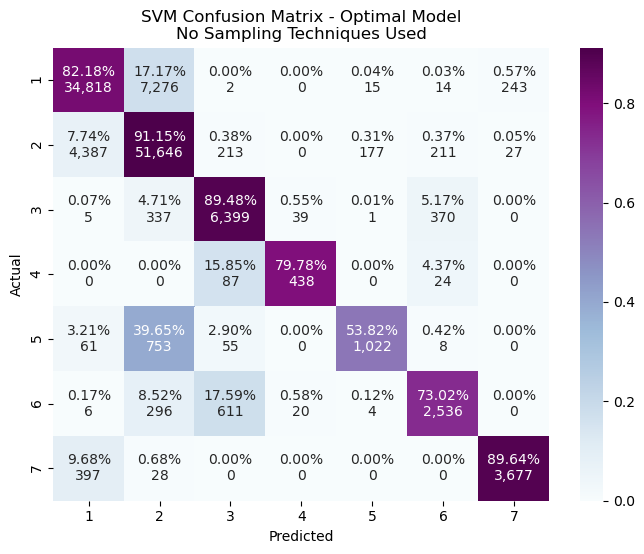

In [55]:
fig = plt.figure(figsize=(8,6), dpi=100)

confusion_matrix1 = pd.crosstab(y_test, 
                               y_pred,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(y_test, 
                               y_pred,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


# Extracting counts and percentages from the matrices above:
counts = ["{0:,}".format(value) for value in
                confusion_matrix1.to_numpy().flatten()]

percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix2.to_numpy().flatten()]

# Combining counts and percentages as one label:
labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

# Reshaping the labels to fit the array:
labels = np.asarray(labels).reshape(7,7)

#Plotting the heatmap:
sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
plt.title("SVM Confusion Matrix - Optimal Model\nNo Sampling Techniques Used")
#plt.savefig('Figures/SVM_Conf_Mat.png', bbox_inches='tight')
plt.show()

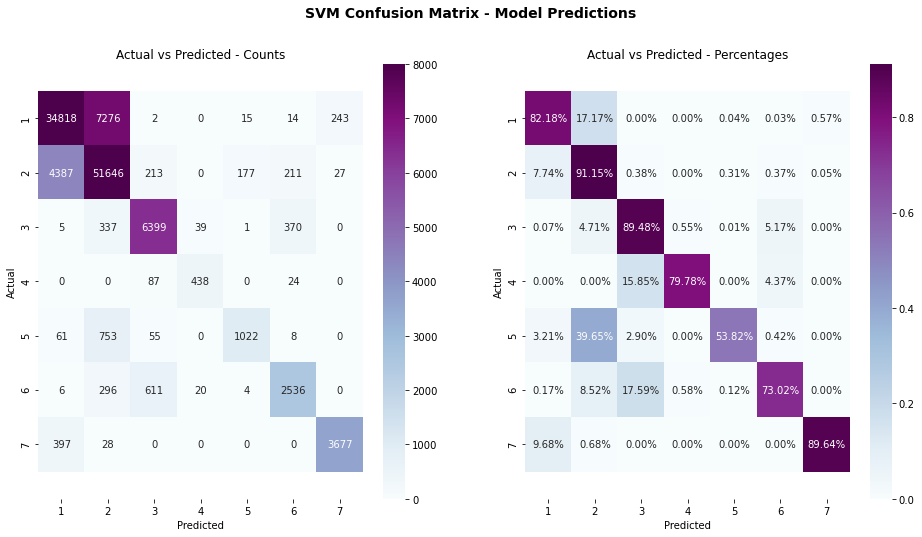

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

confusion_matrix1 = pd.crosstab(y_test, 
                               y_pred,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(y_test, 
                               y_pred,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


sns.heatmap(confusion_matrix1, annot=True, fmt='g', cmap = 'BuPu', vmax = 8000, ax = ax[0])
sns.heatmap(confusion_matrix2, annot=True, fmt=".2%", cmap = 'BuPu', ax = ax[1])

# Using the below to correct for errors in correlogram, making the squares uneven
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[0].set_title("Actual vs Predicted - Counts")
ax[1].set_title("Actual vs Predicted - Percentages")

plt.suptitle("SVM Confusion Matrix - Model Predictions\n", fontsize = (14), fontweight = 'bold')
#plt.savefig('Figures/SVM_Conf_Mat.png', bbox_inches='tight')
plt.show()

## Model Trained with Sampling Techniques:

In [34]:
loaded_samp_model = pickle.load(open('Models/svm_sampled_model.sav', 'rb'))

In [35]:
start = time.time()
y_pred_samp = loaded_samp_model.predict(X_test)
print(time.time() - start)

1753.90625


In [36]:
calc_acc(y_pred_samp, y_test)

85.30932936326946

In [43]:
# Number of Support Vectors:
loaded_samp_model.n_support_.sum()

292138

In [37]:
print(classification_report(y_test, y_pred_samp, labels=[1, 2, 3, 4, 5, 6, 7]))

              precision    recall  f1-score   support

           1       0.86      0.85      0.85     42368
           2       0.90      0.84      0.87     56661
           3       0.88      0.88      0.88      7151
           4       0.74      0.92      0.82       549
           5       0.46      0.97      0.62      1899
           6       0.68      0.90      0.78      3473
           7       0.81      0.99      0.89      4102

    accuracy                           0.85    116203
   macro avg       0.76      0.91      0.82    116203
weighted avg       0.86      0.85      0.86    116203



### Plotting Conf Matrix:

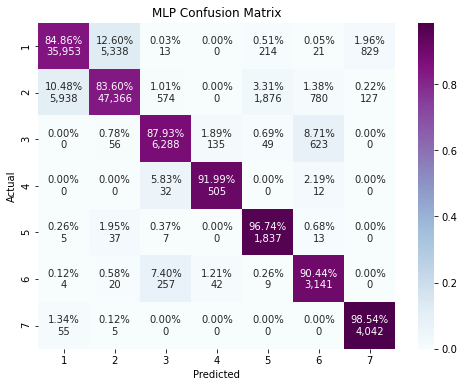

In [48]:
fig = plt.figure(figsize=(8,6), dpi=300)

confusion_matrix1 = pd.crosstab(y_test, 
                               y_pred_samp,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(y_test, 
                               y_pred_samp,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


# Extracting counts and percentages from the matrices above:
counts = ["{0:,}".format(value) for value in
                confusion_matrix1.to_numpy().flatten()]

percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix2.to_numpy().flatten()]

# Combining counts and percentages as one label:
labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

# Reshaping the labels to fit the array:
labels = np.asarray(labels).reshape(7,7)

#Plotting the heatmap:
sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
plt.title("MLP Confusion Matrix")
#plt.savefig('Figures/SVM_Conf_Mat.png', bbox_inches='tight')
plt.show()

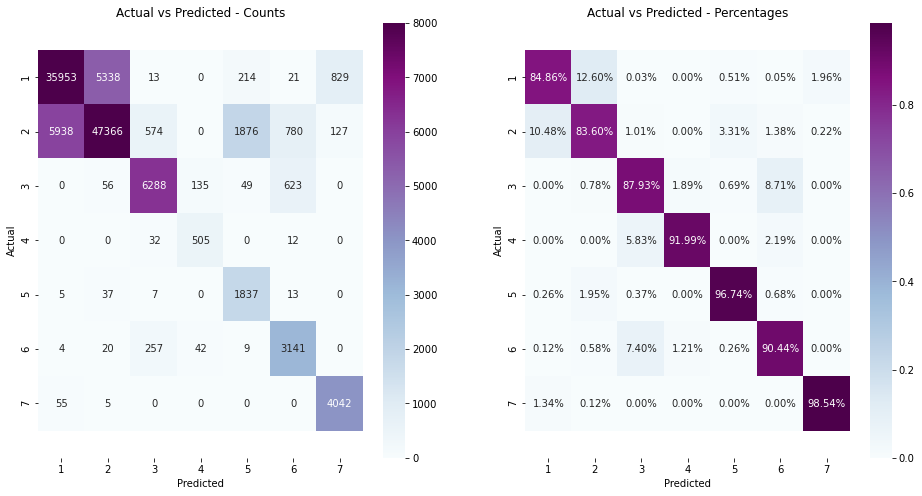

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

confusion_matrix1 = pd.crosstab(y_test, 
                               y_pred_samp,
                               rownames=['Actual'], colnames=['Predicted'])
confusion_matrix2 = pd.crosstab(y_test, 
                               y_pred_samp,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')


sns.heatmap(confusion_matrix1, annot=True, fmt='g', cmap = 'BuPu', vmax = 8000, ax = ax[0])
sns.heatmap(confusion_matrix2, annot=True, fmt=".2%", cmap = 'BuPu', ax = ax[1])

# Using the below to correct for errors in correlogram, making the squares uneven
bottom, top = ax[0].get_ylim()
ax[0].set_ylim(bottom + 0.5, top - 0.5)
bottom, top = ax[1].get_ylim()
ax[1].set_ylim(bottom + 0.5, top - 0.5)
ax[0].set_title("Actual vs Predicted - Counts")
ax[1].set_title("Actual vs Predicted - Percentages")

#plt.suptitle("Confusion Matrix - Model Predictions\n")
plt.show()